In [1]:
from hashlib import md5
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def file_hash(x, note=""):
    h = md5()
    h.update(Path(x).read_bytes())
    print(x, h.hexdigest()[:6], note, sep="\t")

## Data dependencies
```
./data/merge_df.pkl	3edd8f	
./data/all_tsne_df.pkl	ef711d	
```

In [3]:
# all_data.csv might be different
file_hash("./data/merge_df.pkl")
file_hash("./data/all_tsne_df.pkl")

./data/merge_df.pkl	3edd8f	
./data/all_tsne_df.pkl	ef711d	


In [4]:
merge_df = pd.read_pickle('./data/merge_df.pkl')
all_tsne_df = pd.read_pickle('./data/all_tsne_df.pkl')

## Vowel Data

In [5]:
selected_phones = "[aeioɤəu]"
vowel_data = all_tsne_df.loc[all_tsne_df.phone.str.contains(selected_phones), :]
vowel_data.shape

(11326, 4)

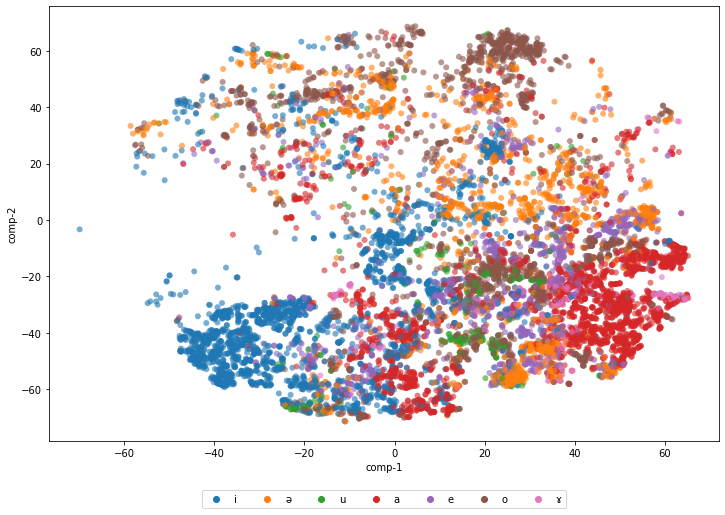

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x="comp-1", y="comp-2", 
                hue="phone",
                palette="tab10",
                alpha=0.6,
                edgecolor="none",
                data=vowel_data)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=8)

## Classifier

In [7]:
def run_linear_svm(clf_data, 
                   feature_col, labelvar, 
                   random_state=1234,
                   only_speakerA=False, select_phone=False, use_acoustic=False):
    
    # optional parameters
    if only_speakerA:
        clf_data = clf_data.loc[clf_data.speaker=='A']
    if select_phone:
        clf_data = clf_data.loc[clf_data.phone.str.contains(selected_phones)]   
    if use_acoustic:
        features = clf_data[["freq_f1", "freq_f2", "freq_f3", "a1p0"]].to_numpy()
        features = minmax_scale(features)        
    else:
        features = clf_data[feature_col].values.tolist()
    
    # X (embedding matrix) & Y (feature array) 
    vec_matrix = pd.DataFrame(features, index=clf_data.phone)  ## use PHONE as index
    x = vec_matrix
    y = clf_data[labelvar].to_numpy()    

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)    

    # fit model 
    clf = SVC(kernel='linear')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(x_train, y_train)
    dummy_pred = dummy.predict(x_test)
    
    print('{} tokens'.format(clf_data.shape[0]))
    if only_speakerA:
        print("Only emit frames containing Speaker_A")

    print(f'x: {feature_col}, y:', labelvar)
    print('x_train:{}, x_test:{}'.format(x_train.shape, x_test.shape),'\n')

    print('Accuracy: {:.4f} / Dummy: {:.4f}'.format(
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, dummy_pred)))
    print('')
    print(classification_report(y_test, y_pred))


In [8]:
def run_nb_transcript(df, labelvar, random_state=1234):
    clf = CategoricalNB()
    X = LabelEncoder().fit_transform(df.transcription)[:,np.newaxis]
    y = df[labelvar]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    clf.fit(x_train, y_train)
    nb_preds = clf.predict(x_test)
    print(classification_report(y_test, nb_preds))

In [9]:
uniq_frames = merge_df.assign(frameid=merge_df.person+"-"+merge_df.offset_id.astype(str))\
                    .drop_duplicates("frameid")
uniq_vowels = uniq_frames.loc[uniq_frames.phone.str.contains(selected_phones), :]
uniq_vowels.shape

(309, 19)

### Unique frames

In [10]:
uniq_frames.shape

(834, 19)

### Role

In [11]:
role_clf_data = run_linear_svm(uniq_frames, 
               feature_col="bilstm", labelvar="role")

834 tokens
x: bilstm, y: role
x_train:(583, 640), x_test:(251, 640) 

Accuracy: 0.8884 / Dummy: 0.7410

              precision    recall  f1-score   support

          BC       0.78      0.82      0.80        17
         CFT       0.78      0.91      0.84        34
  disfluency       0.40      0.29      0.33         7
      filler       0.94      0.94      0.94       186
    response       1.00      0.29      0.44         7

    accuracy                           0.89       251
   macro avg       0.78      0.65      0.67       251
weighted avg       0.89      0.89      0.88       251



In [12]:
run_nb_transcript(uniq_frames, "role")

              precision    recall  f1-score   support

          BC       0.79      0.88      0.83        17
         CFT       1.00      0.03      0.06        34
  disfluency       1.00      0.71      0.83         7
      filler       0.82      0.99      0.90       186
    response       0.00      0.00      0.00         7

    accuracy                           0.82       251
   macro avg       0.72      0.52      0.52       251
weighted avg       0.82      0.82      0.75       251



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Meaning

In [13]:
run_linear_svm(uniq_frames, 
               feature_col="bilstm", labelvar="meaning")

834 tokens
x: bilstm, y: meaning
x_train:(583, 640), x_test:(251, 640) 

Accuracy: 0.6614 / Dummy: 0.2709

                           precision    recall  f1-score   support

                authority       0.34      0.82      0.48        17
        authority,concern       1.00      1.00      1.00         1
authority,dissatisfaction       1.00      0.50      0.67         2
                  concern       0.69      0.75      0.72        12
                  control       0.57      0.65      0.61        46
       control,old_ground       0.00      0.00      0.00         2
          control,thought       0.50      1.00      0.67         1
          dissatisfaction       0.75      0.38      0.50         8
                  neutral       0.63      0.59      0.61        56
                 new_info       0.25      0.25      0.25         4
               old_ground       0.79      0.44      0.57        34
                  thought       0.95      0.85      0.90        68

                 acc

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
run_nb_transcript(uniq_frames, "meaning")

                           precision    recall  f1-score   support

                authority       0.11      0.06      0.08        17
        authority,concern       0.00      0.00      0.00         1
authority,dissatisfaction       0.00      0.00      0.00         2
                  concern       0.00      0.00      0.00        12
                  control       0.00      0.00      0.00        46
       control,old_ground       0.00      0.00      0.00         2
          control,thought       0.00      0.00      0.00         1
          dissatisfaction       1.00      0.25      0.40         8
                  neutral       0.30      0.86      0.45        56
                 new_info       1.00      0.25      0.40         4
               old_ground       1.00      0.15      0.26        34
                  thought       0.88      0.97      0.92        68

                 accuracy                           0.49       251
                macro avg       0.36      0.21      0.21    

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
run_linear_svm(uniq_frames, 
               feature_col="bilstm", labelvar="transcription")

834 tokens
x: bilstm, y: transcription
x_train:(583, 640), x_test:(251, 640) 

Accuracy: 0.8845 / Dummy: 0.4980

              precision    recall  f1-score   support

          eh       0.89      1.00      0.94         8
          ha       1.00      0.50      0.67         2
          he       1.00      1.00      1.00         2
          ho       0.85      0.98      0.91       125
           i       1.00      1.00      1.00         1
       la-ho       1.00      1.00      1.00         1
    laughter       0.00      0.00      0.00         1
           m       0.88      0.79      0.83        19
          oh       1.00      0.58      0.74        12
        sisi       0.00      0.00      0.00         1
          uh       0.94      0.87      0.90        68
          um       1.00      0.71      0.83         7
         w,w       0.00      0.00      0.00         3
          wa       0.00      0.00      0.00         1

    accuracy                           0.88       251
   macro avg       0.

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Unique vowelsuniq_frames

In [16]:
uniq_vowels.shape

(309, 19)

In [17]:
run_linear_svm(uniq_vowels, 
               feature_col="bilstm", labelvar="role")

309 tokens
x: bilstm, y: role
x_train:(216, 640), x_test:(93, 640) 

Accuracy: 0.8387 / Dummy: 0.7849

              precision    recall  f1-score   support

          BC       1.00      0.50      0.67         6
         CFT       0.67      0.31      0.42        13
  disfluency       0.00      0.00      0.00         1
      filler       0.86      0.97      0.91        73
    response       0.00      0.00      0.00         0

    accuracy                           0.84        93
   macro avg       0.50      0.36      0.40        93
weighted avg       0.83      0.84      0.82        93



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Rec

In [18]:
run_linear_svm(uniq_vowels, 
               feature_col="bilstm", labelvar="meaning")

309 tokens
x: bilstm, y: meaning
x_train:(216, 640), x_test:(93, 640) 

Accuracy: 0.5699 / Dummy: 0.3118

                           precision    recall  f1-score   support

                authority       0.33      0.20      0.25        10
authority,dissatisfaction       1.00      1.00      1.00         1
                  concern       0.00      0.00      0.00         2
                  control       0.53      0.44      0.48        18
          control,thought       0.00      0.00      0.00         1
          dissatisfaction       0.00      0.00      0.00         1
                  neutral       0.38      0.42      0.40        19
                 new_info       0.00      0.00      0.00         2
               old_ground       0.46      0.60      0.52        10
                  thought       0.78      0.97      0.86        29

                 accuracy                           0.57        93
                macro avg       0.35      0.36      0.35        93
             weighted

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
run_linear_svm(uniq_vowels, 
               feature_col="bilstm", labelvar="transcription")

309 tokens
x: bilstm, y: transcription
x_train:(216, 640), x_test:(93, 640) 

Accuracy: 0.8925 / Dummy: 0.4624

              precision    recall  f1-score   support

          eh       1.00      0.86      0.92         7
          ha       0.00      0.00      0.00         1
          he       0.00      0.00      0.00         0
          ho       0.89      0.98      0.93        43
           m       1.00      0.80      0.89         5
          oh       0.50      0.50      0.50         2
          uh       0.91      0.91      0.91        32
          um       1.00      1.00      1.00         1
         w,w       0.00      0.00      0.00         1
          wa       0.00      0.00      0.00         1

    accuracy                           0.89        93
   macro avg       0.53      0.50      0.52        93
weighted avg       0.88      0.89      0.88        93



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Rec